# **Subscription Mechanism Demonstration**
## *Connection with Orion Context Broker*
We assume that there is a broker up and running. Then we have to tell the NGSI-LD client to point to the broker by providing its **IP address** and **TCP port**. The Client constructor takes many optional arguments. For example: **hostname** defaults to localhost, **port** defaults to 1026, **tenant** not set by default. It is possible to use HTTPS by setting the **secure** boolean argument to true. If the **overwrite** argument is set, the client will always upsert entities and will not complain about already existing ones.

In [ ]:
from ngsildclient import Client

#connection with overwrite strategy enabled
orionld_ctxbrk= Client("localhost", port=1026, overwrite=True) #using simply Client() will give the same result

print(orionld_ctxbrk.is_connected())

## *Creation of Entities*
This part is used for creating two entities of the same type with one attribute. *Note: if the entities already exist, an error will be raised*

In [ ]:
from ngsildclient import Entity

#batch entities creation 
e1 = Entity("AirQualityObserved", "Bordeaux-AirProbe1").prop("NO2", 8)
e2 = Entity("AirQualityObserved", "Bordeaux-AirProbe2").prop("NO2", 9)
entities = [e1, e2]
orionld_ctxbrk.create(e1,e2)

## Subscriptions mechanism
The second option for data retrival is the **subscription to individual context entities and persisting them into a time-series database**. A possibility is the usage of QuantumLeap (this means changing again the docker-compose).

*Note*: Subscribe = receive notifications of context changes. It’s the opposite of pooling. **Actions are triggered on the broker side as in a pub/sub HTTP-based model.** In API terms it means: create a Subscription that will POST a payload to a “well-known” URL whenever a value has changed.  

The Orion Context Broker offers also an *asynchronous notification mechanism* - applications can subscribe to changes of context information so that they can be informed when something happens. This means the application does not need to continuously poll or repeat query requests. Use of the subscription mechanism will therefore reduce both the volume of requests and amount of data being passed between components within the system. This reduction in network traffic will improve the overall responsiveness.

The use of the **SubscriptionBuilder** gives us an easy way of making a subscription POST with all the required and optional parameters managed by Orion Broker. In the example it's specified the notification endpoint, the entity type and attribute that triggers the notification (other parameters and expressions can be seen here: https://fiware-orion.readthedocs.io/en/master/user/walkthrough_apiv2.html)

In [ ]:
from ngsildclient import SubscriptionBuilder

payload = SubscriptionBuilder("http://fiware-quantumleap:8668/v2/notify").description("Notify me of high NO2 level").select_type("AirQualityObserved").watch(["NO2"]).build()
print(payload)
subscr_id=orionld_ctxbrk.subscriptions.create(payload)

Orion **does not** check if the notification endpoint exists/is correct. One way to check whether the subscription was successful is to trigger the notification system. Here both entities are periodically updated with a random value every ten seconds for a hundred times.

In [ ]:
import random
import time

#update batch of entities
for i in range(1,100):
    for e in entities:
        e["NO2.value"] = random.randrange(10,20)
    orionld_ctxbrk.update(entities)
    #wait for ten seconds
    time.sleep(10)

Variation in the data can be evaluated using Grafana. 

*Note*: a data source must be set into Grafana settings in order to access to Timescale DB

### Setting up the database in Grafana
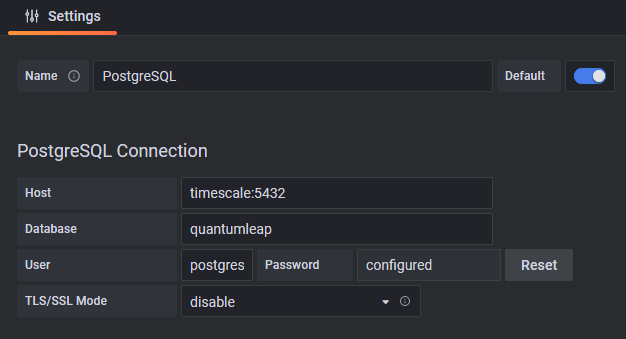

### Exploring the time-series DB with Grafana
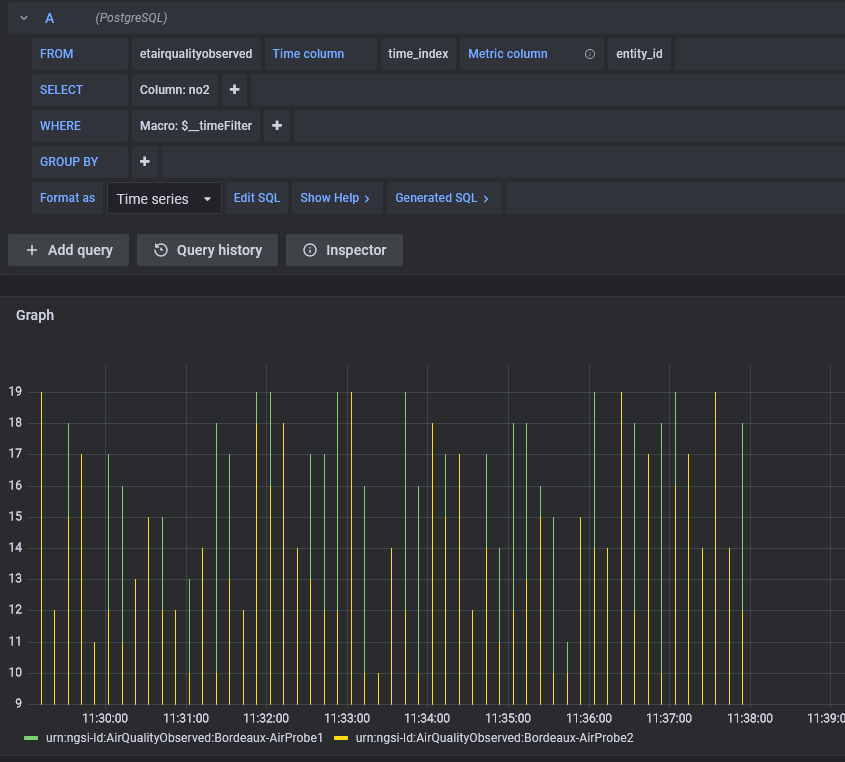